In [51]:
from IPython.display import HTML
HTML("""
<style>
h1,h2,h3 {
	margin: 1em 0 0.5em 0;
	font-weight: 600;
	font-family: 'Titillium Web', sans-serif;
	position: relative;  
	font-size: 36px;
	line-height: 40px;
	padding: 15px 15px 15px 2.5%;
	color: #00018D;
	box-shadow: 
		inset 0 0 0 1px rgba(97,0,45, 1), 
		inset 0 0 5px rgba(53,86,129, 1),
		inset -285px 0 35px #F2D8FF;
	border-radius: 0 10px 0 15px;
	background: #FFD8B2
    
}
</style>
""")

<h1 style="background-color:#FF85A3;font-size:20px;color:#00033E;font-weight : bold">✅ Importing Required Libraries</h1>

In [52]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
import numpy as np
from sklearn.model_selection import train_test_split
import math
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import RandomizedSearchCV
import re
import time
import string
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Conv1D, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import glob

%matplotlib inline

# Importing plaintext data files

In [53]:
cols = ['text']
plaintext_files=pd.DataFrame()
address = glob.glob('/kaggle/input/clinical-documents-on-syndromes-disease/plaintext_data/*.txt')
count=0
for i in address:
    with open(i, "rb") as data_of_files:
        data=pd.read_csv(data_of_files, sep='\t', header=None, names=cols)
        plaintext_files=pd.concat([plaintext_files,data['text']], axis=0)
        count=count+1
        if count==493:
            break  

plaintext_files=plaintext_files.rename(columns={0:'text'})          
plaintext_files.head(10)

,text
0,PREOPERATIVE DIAGNOSES:
1,1. Feeding disorder.
2,2. Down syndrome.
3,3. Congenital heart disease.
4,POSTOPERATIVE DIAGNOSES:
5,1. Feeding disorder.
6,2. Down syndrome.
7,3. Congenital heart disease.
8,OPERATION PERFORMED:
9,Gastrostomy.


### Cleaning and removing punctuations 

In [54]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [55]:
plaintext_files["text"] = plaintext_files["text"].apply(lambda x: cleaning_punctuations(x))

### Cleaning special character 

In [56]:
def cleaning_characters(text): 
    
    text = re.sub(r'#([^\s]+)', r'\1', text)
    
    return text

In [57]:
plaintext_files["text"] = plaintext_files["text"].apply(lambda x: cleaning_characters(x))
plaintext_files

,text
0,PREOPERATIVE DIAGNOSES
1,1 Feeding disorder
2,2 Down syndrome
3,3 Congenital heart disease
4,POSTOPERATIVE DIAGNOSES
...,...
19,Extremities No clubbing cyanosis edema or def...
20,NEUROLOGICAL EXAMINATION
21,Mental Status The patient is awake alert and ...
22,Cranial Nerves


###  Making the sentences of plain text sentences into words in each row

In [58]:
plaintext_files= plaintext_files.text.str.split(expand=True).stack()
plaintext_files

0   0     PREOPERATIVE
    1        DIAGNOSES
1   0                1
    1          Feeding
    2         disorder
              ...     
21  71              or
    72         aphasia
22  0          Cranial
    1           Nerves
23  0               II
Length: 200071, dtype: object

# Importing ground truth annotation file

In [59]:
ground_truth=pd.read_csv('/kaggle/input/clinical-documents-on-syndromes-disease/ground_truth_annotation_file.csv')
ground_truth.head()

,file,start,end,text,class
0,12_Neurology.txt,1935,1939,head,Others
1,12_Neurology.txt,1947,1967,left caudate nucleus,Others
2,12_Neurology.txt,2008,2016,arterial,Others
3,12_Neurology.txt,2041,2044,MCA,Others
4,12_Neurology.txt,2366,2369,MCA,Others


### Taking the text in list

In [60]:
li=list(ground_truth['text'])
li

['head',
 'left caudate nucleus',
 'arterial',
 'MCA',
 'MCA',
 'MCA',
 'MCA',
 'MCA',
 'right nasolabial fold',
 'neck',
 'extremities',
 'extremities',
 'abdominal',
 'flexor',
 'pelvic',
 'right putamen',
 'subcortical',
 'right basal ganglia',
 'ACA',
 'ACA',
 'ROS',
 'edema',
 'squamous cell cancer of the cervix',
 'vasculopathy',
 'fibromuscular dysplasia',
 'cervical cancer',
 'HIV',
 'vasculitis',
 'confusion',
 'flu-like illness',
 'passed out',
 'confused',
 'lethargic',
 'emotional lability',
 'facial weakness',
 'headache',
 'nausea',
 'fever',
 'chills',
 'neck stiffness',
 'moya moya disease',
 'cognitive dysfunction',
 'impairment',
 'migraine headache',
 'illicit drug use',
 'mental status change',
 'hemiparesis',
 'impaired writing',
 'pronator drift',
 'pronator drift',
 'lacunar infarct',
 'uterus',
 'cervix',
 'adnexa',
 'BPD',
 'uterus',
 'cervix',
 'placenta previa',
 'uterus',
 'cervix',
 'adnexa',
 'BPD',
 'left ovary',
 'right ovary',
 'can',
 'uterus',
 'torsi

### Matching the ground_truth with the plain text and creating the sentence, word and tag

In [61]:
Processed_data=pd.DataFrame({
    'Sentence#': plaintext_files.index.get_level_values(0) + 1, 
    'Word': plaintext_files.values, 
    'Tag': plaintext_files.map(dict(zip(ground_truth.text, ground_truth['class']))).fillna(0).values
})

# Exploratory data analysis

#### Five top records of Processed_data

In [64]:
Processed_data.head()

,Sentence#,Word,Tag
0,1,PREOPERATIVE,0
1,1,DIAGNOSES,0
2,2,1,0
3,2,Feeding,0
4,2,disorder,Others


#### Five last records of Processed_data

In [65]:
Processed_data.tail()

,Sentence#,Word,Tag
200066,22,or,0
200067,22,aphasia,Disease_Syndrome
200068,23,Cranial,0
200069,23,Nerves,0
200070,24,II,0


#### Coloumns/features in Processed_data

In [66]:
Processed_data.columns

Index(['Sentence#', 'Word', 'Tag'], dtype='object')

#### Length of Processed_data

In [67]:
print('lenght of Processed_data is', len(Processed_data))

lenght of Processed_data is 200071


#### Shape of Processed_data

In [68]:
Processed_data.shape

(200071, 3)

#### Processed_data information

In [69]:
Processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200071 entries, 0 to 200070
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentence#  200071 non-null  int64 
 1   Word       200071 non-null  object
 2   Tag        200071 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


#### Processed_data types of all coloumns

In [70]:
Processed_data.dtypes

Sentence#     int64
Word         object
Tag          object
dtype: object

#### Checking Null values

In [71]:
np.sum(Processed_data.isnull().any(axis=1))

0

#### Rows and columns in the Processed_dataset

In [72]:
print('Count of columns in the Processed_data is:  ', len(Processed_data.columns))

Count of columns in the Processed_data is:   3


In [73]:
print('Count of rows in the Processed_data is:  ', len(Processed_data))

Count of rows in the Processed_data is:   200071


#### Checking duplicate Processed_data

In [74]:
current=len(Processed_data)
print('Rows of Processed_data before Delecting ', current)

Rows of Processed_data before Delecting  200071


In [75]:
now=len(Processed_data)
print('Rows of Processed_data before Delecting ', now)

Rows of Processed_data before Delecting  200071


In [76]:
diff=current-now
print('Duplicated rows are ', diff)

Duplicated rows are  0


#### Count of the class

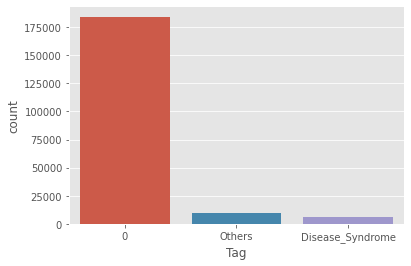

In [77]:
sns.countplot(data= Processed_data, x = "Tag")
plt.show()

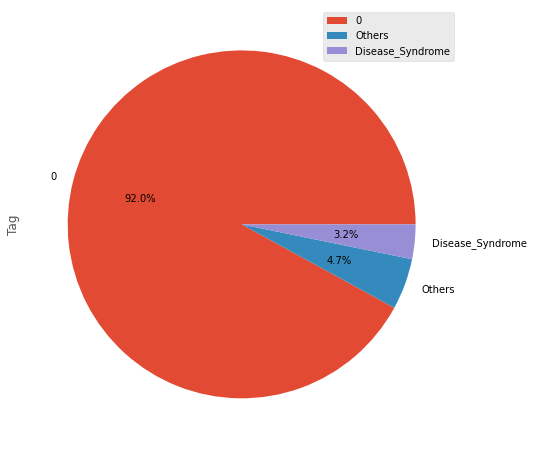

In [78]:
Processed_data["Tag"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

In [79]:
Processed_data["Tag"].value_counts()

0                   184143
Others                9500
Disease_Syndrome      6428
Name: Tag, dtype: int64

### Words tagged as Others

In [80]:
Processed_data.loc[Processed_data['Tag'] == 'Others', 'Word'].head()

4     disorder
7     syndrome
10       heart
11     disease
16    disorder
Name: Word, dtype: object

### Words tagged as Disease_Syndrome      

In [81]:
Processed_data.loc[Processed_data['Tag'] == 'Disease_Syndrome', 'Word'].head()

141          cavity
209          cavity
259         sterile
295    hypertension
305     hemiparesis
Name: Word, dtype: object

### Words tagged as 0      

In [82]:
Processed_data.loc[Processed_data['Tag'] == 0, 'Word'].head()

0    PREOPERATIVE
1       DIAGNOSES
2               1
3         Feeding
5               2
Name: Word, dtype: object

# Data Preparation

### Making text text in lower case

In [83]:
Processed_data['Word']=Processed_data['Word'].str.lower()

### Applying Stemming

In [84]:
st = nltk.PorterStemmer()
def stemming_on_text(Processed_data):
    text = [st.stem(word) for word in Processed_data]
    return Processed_data

Processed_data["Word"] = Processed_data["Word"].apply(lambda x: stemming_on_text(x))

### Applying Lemmatizer
- We used the lemmatization because it helps to achieve the roots of the words. Since we are working on the words basis so it is very important to know each word with its root not many words which give the same meaning. 

In [85]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(Processed_data):
    text = [lm.lemmatize(word) for word in Processed_data]
    return Processed_data

Processed_data["Word"] = Processed_data["Word"].apply(lambda x: lemmatizer_on_text(x))

### Taking only Others and Disease_Syndrome

In [86]:
aa=Processed_data[Processed_data['Tag']=='Others']
bb=Processed_data[Processed_data['Tag']=='Disease_Syndrome']
Processed_data=pd.concat([aa,bb])
Processed_data

,Sentence#,Word,Tag
4,2,disorder,Others
7,3,syndrome,Others
10,4,heart,Others
11,4,disease,Others
16,6,disorder,Others
...,...,...,...
199985,20,edema,Disease_Syndrome
200022,22,depressed,Disease_Syndrome
200062,22,confusion,Disease_Syndrome
200065,22,dysnomia,Disease_Syndrome


#### Count of the class

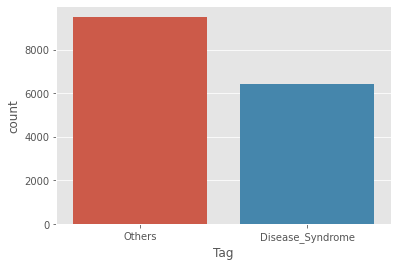

In [87]:
sns.countplot(data= Processed_data, x = "Tag")
plt.show()

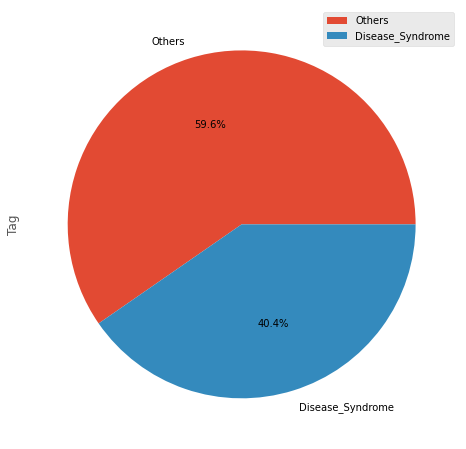

In [88]:
Processed_data["Tag"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

#### Encoding the Others as 0 and Disease_Syndrome as 1

In [89]:
Processed_data['Tag']=Processed_data['Tag'].replace('Others',1)
Processed_data['Tag']=Processed_data['Tag'].replace('Disease_Syndrome',2)

#### Getting inpout and output features

In [90]:
X = Processed_data.Word
Y = Processed_data['Tag']
le=LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

#### Features Extraction using sequance extractor 
- Tensorflow sequence extractor transforms each word in text to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. By doing this, it use the words with top frequency as features. Since we used the tokenizor, so the words for sequence extractor taken into account which are known by the tokenizor. 
- We selected the 1500 maximum words window to extract from the data using tensorflow text to sequences method. The words are on one side as single feature vector and maximum length of word is 300. 

In [91]:
max_words = 1500
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [92]:
sequences_matrix

array([[   0,    0,    0, ...,    0,    0,   60],
       [   0,    0,    0, ...,    0,    0,   66],
       [   0,    0,    0, ...,    0,    0,    6],
       ...,
       [   0,    0,    0, ...,    0,    0,  136],
       [   0,    0,    0, ...,    0,    0, 1096],
       [   0,    0,    0, ...,    0,    0,  184]], dtype=int32)

#### Split data into training and testing
- 70% training data 
- 30% testing data


In [93]:
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, Y, test_size=0.30, random_state=2)

<div class="alert alert-block alert-info">  
    <h6>...</h6>
    <h6>...</h6>
    <h6>...</h6>
    <h1><strong><center>RNN Model</center></strong></h1>
    <h6>...</h6>
    <h6>...</h6>
    <h6>...</h6>
    <i></i>
</div>

# Implementing RNN model
- building the RNN with Hyper parameter
- Tunning the hyper parameter accroding to the problem 
- We used 9 layers in the RNN model in which one is input layer and one is output layer. We used word embedding and LSTM layers to learn the patterns even better. We used RNN because it remembers the each and every information though the time. RNN model save the previous information and take the better decisions for classification. 

In [94]:
def RNN_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [95]:
model = RNN_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['acc'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 50)           75000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

#### Training and validating 

- from 70% of the training data, we used 10% for validation

In [96]:
history=model.fit(X_train,y_train,batch_size=500,epochs=20,
          validation_split=0.1)
print('Training finished !!')

Epoch 1/20
21/21 [==============================] - 19s 797ms/step - loss: 0.6718 - acc: 0.5861 - val_loss: 0.5748 - val_acc: 0.6000
Epoch 2/20
21/21 [==============================] - 17s 797ms/step - loss: 0.4706 - acc: 0.8006 - val_loss: 0.1837 - val_acc: 0.9704
Epoch 3/20
21/21 [==============================] - 16s 780ms/step - loss: 0.1287 - acc: 0.9797 - val_loss: 0.1320 - val_acc: 0.9399
Epoch 4/20
21/21 [==============================] - 17s 791ms/step - loss: 0.0407 - acc: 0.9931 - val_loss: 0.0301 - val_acc: 0.9919
Epoch 5/20
21/21 [==============================] - 17s 800ms/step - loss: 0.0119 - acc: 0.9991 - val_loss: 0.2525 - val_acc: 0.9121
Epoch 6/20
21/21 [==============================] - 17s 784ms/step - loss: 0.0376 - acc: 0.9861 - val_loss: 0.0447 - val_acc: 0.9812
Epoch 7/20
21/21 [==============================] - 16s 786ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.0204 - val_acc: 0.9901
Epoch 8/20
21/21 [==============================] - 16s 777ms/step - 

#### Training and validation plot

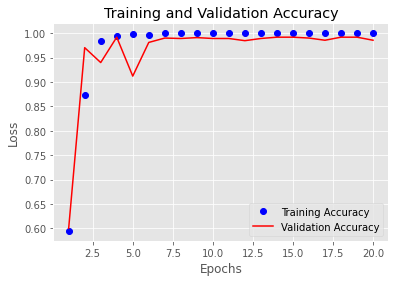

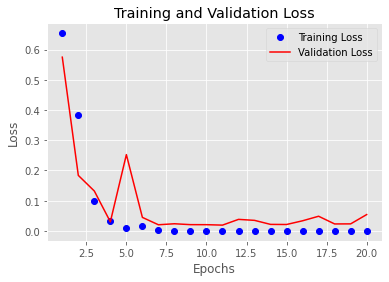

In [97]:
def Training_and_validation_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
Training_and_validation_plot(history)

#### Highest Validation accuracy point

Text(9, 1.0119282793998718, '0.9919')

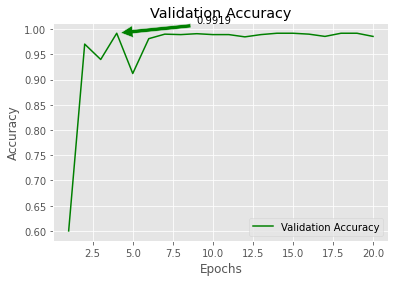

In [98]:
val_acc = history.history['val_acc']
acc = history.history['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='green', shrink=0.05))

#### Accuracy

In [99]:
y_pred1 = model.predict(X_test)
y_pred1=(y_pred1 > 0.5)
accr = model.evaluate(X_test,y_test)
rnn_acc=accr[1]
print('Test set\n   Accuracy: {:0.3f}'.format(accr[1]))

150/150 [==============================] - 6s 41ms/step - loss: 0.0582 - acc: 0.9849
Test set
   Accuracy: 0.985


#### Precision, Recall, F1

In [100]:
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2844
           1       1.00      0.96      0.98      1935

    accuracy                           0.98      4779
   macro avg       0.99      0.98      0.98      4779
weighted avg       0.99      0.98      0.98      4779





#### Confusion Matrix

In [101]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)



confusion matrix


[[2842    2]
 [  70 1865]]


#### AUC curve plot

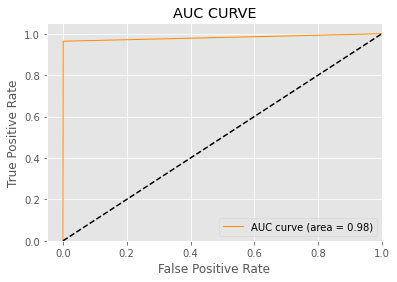

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='AUC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC CURVE')
plt.legend(loc="lower right")
plt.show()

<div class="alert alert-block alert-success">  
    <h6>...</h6>
    <h6>...</h6>
    <h6>...</h6>
    <h1><strong><center>RF Model</center></strong></h1>
    <h6>...</h6>
    <h6>...</h6>
    <h6>...</h6>
    <i></i>
</div>

# Implementing Random Forest model
- Random forest model works in the tree form. Various trees save the information of input features and decides the output class and then finally combine all the trees, calculate the weights and classify. RF model add adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model. 

### Training the Algorithm with Random Search for Hyper parameter Optimization

In [103]:
RF = RandomForestClassifier()

In [104]:
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [105]:
Grid_RN = RandomizedSearchCV(estimator = RF, param_distributions = params)
Grid_RN.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 500]})

### Best parameters

In [106]:
Grid_RN.best_params_

{'n_estimators': 200,
 'max_features': 'log2',
 'max_depth': 8,
 'criterion': 'gini'}

# Testing and calculating Accuracy

#### Accuracy

In [107]:
RF_R=Grid_RN.predict(X_test)
RF_acc=Grid_RN.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(Grid_RN.score(X_test, y_test)))

Accuracy score= 0.82


#### Precision, Recall, F1

In [108]:
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, RF_R)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2844
           1       0.88      0.64      0.74      1935

    accuracy                           0.82      4779
   macro avg       0.84      0.79      0.80      4779
weighted avg       0.83      0.82      0.81      4779





#### Confusion Matrix

In [109]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, RF_R)
print(CR)



confusion matrix


[[2679  165]
 [ 692 1243]]


#### AUC curve plot

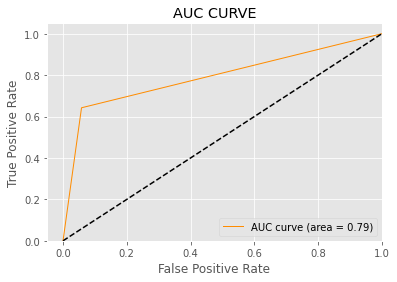

In [110]:
fpr, tpr, thresholds = roc_curve(y_test, RF_R)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='AUC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC CURVE')
plt.legend(loc="lower right")
plt.show()

# Comparison of RNN and Random Forest Results 

In [111]:
x = PrettyTable()
print('\n')
print("Comparison of RNN and Random Forest Results")
x.field_names = ["Model", "Accuracy"]

x.add_row(["RNN model",  round(rnn_acc,2)])
x.add_row(["Random Forest model", round(RF_acc,3)])

print(x)
print('\n')



Comparison of RNN and Random Forest Results
+---------------------+----------+
|        Model        | Accuracy |
+---------------------+----------+
|      RNN model      |   0.98   |
| Random Forest model |  0.821   |
+---------------------+----------+




We trained recurrent neural network RNN and random forest on this data. As we can see that Random Forest Model did not performed well but RNN outperformed with highets accuracy. Initially RNN was not giving good results but we tuned the parameters in order to get the good results. 

RNN model is not giving only high accuracy but also performing well on the other evaluation metrics which are confusion matrix, precision, recall, F1 measure and also can see the AUC curve which is showing high positive rate of classification. 

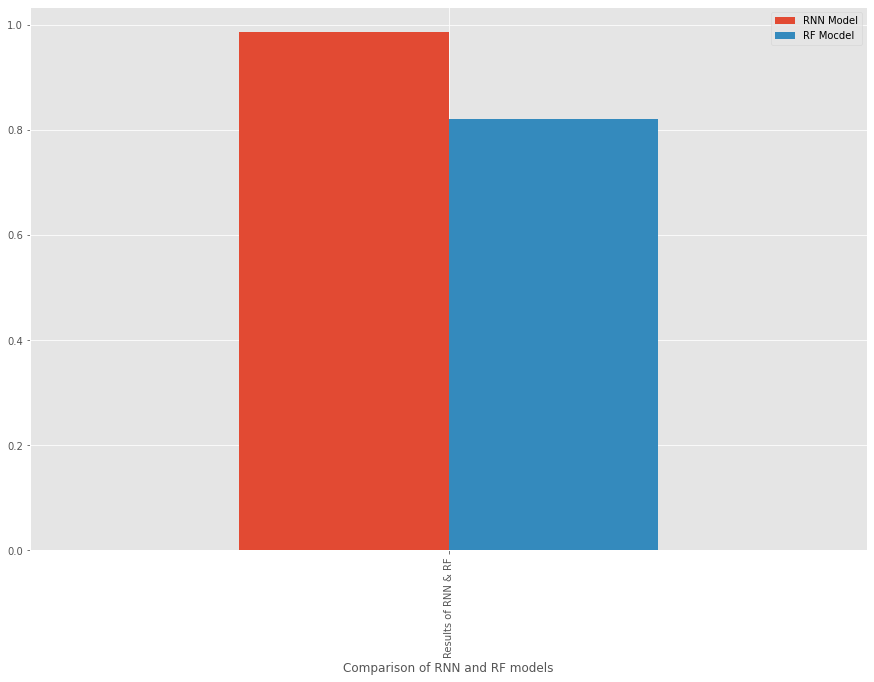

In [112]:
Acc = [['Results of RNN & RF', rnn_acc, RF_acc]]
Acc = pd.DataFrame (Acc, columns = ['Comparison of RNN and RF models','RNN Model', 'RF Mocdel'])
Acc.set_index("Comparison of RNN and RF models",drop=True,inplace=True)
Acc.plot(kind='bar',figsize=(15, 10)).legend(bbox_to_anchor=(1, 1))

# Conclusion

We applied different techniques on the data preparation and then features extraction. We used TF-IDF technique to extract the features from the text but the models was not giving good results. We changed the features extraction technique to Sequance extractor using tensorflow and we got the good results. Data preprocessing, data extraction and hyper parameter tuning helped to boost the perofrmance of RNN but Random forest did not performed well. 


Well about the hyper parameters tuning, we don’t need to set different hyper parameters, train the model and show the results. 
To do this what we need to do, we tune the hyper parameters according to problem, we train and test and know how the model giving results in deep learning. And in Random forest model, we can use GRID SEARCH approach that train the model on all the given hyper parameters and select the best parameters to train the final model.

Hyper parameters for RNN,  
We choose the different number of parameters but after tuning, we got best hyper parameters to get the good results. We used Sigmoid activation function as we need only one output. Sigmoid function helps to get one output for binary problem. We used binary cross entropy as our problem is to classify only two classes. RMSPROP optimizer helps to get the good results. We change and test different epochs and batch sizes but 20 epochs and 500 batch size is good to get the good results as well. 


Hyper parameters for RF,  
To get the best parameters of random forest model, we used grid search which take different parameters every time and train the model. Finally grid search train the model on the best parameters. These are the best parameters for RF model:
{'n_estimators': 200,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'gini'}

We got good results on the RNN because it remember each and every information of previous times.